**Step 1. Import Libraries**

In [520]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict
import pickle

import numpy as np

import IPython

**Step 2. Design Layers**

**2.a linear layer** - Also known as Dense layers

In [521]:
class MyLinear(nn.Module):
    """Linear layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_size, output_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True):
        super().__init__()
        he_std = gain * input_size**(-0.5) # He init - activation function

        # Equalized learning rate and custom learning rate multiplier.
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_size, input_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_size))
            self.b_mul = lrmul
        else:
            self.bias = None

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        return F.linear(x, self.weight * self.w_mul, bias)

In [522]:
gain = 2**(0.5)
gain

1.4142135623730951

In [523]:
he_std = gain*(512**(-0.5)) # input_size = 512
he_std

0.06250000000000001

In [524]:
lrmul = 1
init_std = 1.0/lrmul
print(init_std)
print('w_mul when use wscale :',he_std*init_std)

1.0
w_mul when use wscale : 0.06250000000000001


In [525]:
torch.randn(512,512)*init_std

tensor([[-2.1206,  0.3721,  0.6855,  ...,  0.8124,  0.7778, -0.1313],
        [ 0.4407,  1.8155, -0.6888,  ...,  1.3875,  0.2391, -0.3927],
        [-0.5433, -0.6012,  0.8717,  ..., -1.2929, -0.3489, -0.3113],
        ...,
        [ 0.3254,  1.7984, -1.0399,  ..., -1.8038,  0.7413,  0.4943],
        [-0.4792,  0.2008,  0.2684,  ...,  1.0802, -0.6393,  0.7715],
        [-1.3701, -1.2480, -0.9680,  ...,  1.9505, -0.8113, -0.3605]])

In [526]:
weight = torch.nn.Parameter(torch.randn(512,512)*init_std)
weight

Parameter containing:
tensor([[ 0.2251, -0.0988,  0.9578,  ...,  1.5627,  0.3370, -0.5966],
        [-0.6244,  0.4445,  0.6098,  ..., -0.9224,  1.0194, -1.4506],
        [ 0.4681,  0.0305, -0.1670,  ..., -0.4373,  1.2018, -0.7342],
        ...,
        [-0.4940, -0.8934,  0.5785,  ..., -0.0075, -0.9571,  1.6864],
        [-0.3614, -1.0786,  0.7104,  ...,  0.7176,  2.0296,  0.2402],
        [-0.3413,  2.2748, -0.5247,  ...,  0.0481,  0.1130,  1.9232]],
       requires_grad=True)

In [527]:
bias = torch.nn.Parameter(torch.zeros(512,512))
bias

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [528]:
w_mul = lrmul
b_mul = lrmul

F.linear(torch.randn(512,512), weight*w_mul, bias*b_mul)

tensor([[-10.1434,   0.4724,  34.1469,  ..., -19.0917,  25.8579,  11.6434],
        [ 33.6453, -10.6791,   7.5501,  ..., -29.6879,  10.5996,  16.3313],
        [ 13.6762,  11.2302, -18.8115,  ...,  -0.6106,   1.5384, -12.7520],
        ...,
        [  0.0675, -18.2660,   9.9055,  ...,  12.8736, -35.4491, -42.0348],
        [ -7.0214, -41.9499, -36.5587,  ...,  26.8609, -33.0597,  20.1774],
        [ 29.0355,  31.6223,  -0.9900,  ..., -13.3953,  19.1797, -16.2897]],
       grad_fn=<AddmmBackward0>)

**2-b. Convolution Layer**

In [529]:
class MyConv2d(nn.Module):
    """Conv layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_channels, output_channels, kernel_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True,
                intermediate=None, upscale=False):
        super().__init__()
        if upscale:
            self.upscale = Upscale2d()
        else:
            self.upscale = None
        he_std = gain * (input_channels * kernel_size ** 2) ** (-0.5) # He init
        self.kernel_size = kernel_size
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_channels, input_channels, kernel_size, kernel_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_channels))
            self.b_mul = lrmul
        else:
            self.bias = None
        self.intermediate = intermediate

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul

        have_convolution = False
        if self.upscale is not None and min(x.shape[2:]) * 2 >= 128:
            w = self.weight * self.w_mul
            w = w.permute(1, 0, 2, 3)
            w = F.pad(w, (1,1,1,1))
            w = w[:, :, 1:, 1:]+ w[:, :, :-1, 1:] + w[:, :, 1:, :-1] + w[:, :, :-1, :-1]
            x = F.conv_transpose2d(x, w, stride=2, padding=(w.size(-1)-1)//2)
            have_convolution = True
        elif self.upscale is not None:
            x = self.upscale(x)

        if not have_convolution and self.intermediate is None:
            return F.conv2d(x, self.weight * self.w_mul, bias, padding=self.kernel_size//2)
        elif not have_convolution:
            x = F.conv2d(x, self.weight * self.w_mul, None, padding=self.kernel_size//2)

        if self.intermediate is not None:
            x = self.intermediate(x)
        if bias is not None:
            x = x + bias.view(1, -1, 1, 1)
        return x

**2-c. Noise Layer**

In [530]:
class NoiseLayer(nn.Module):
    """adds noise. noise is per pixel (constant over channels) with per-channel weight"""
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(channels))
        self.noise = None

    def forward(self, x, noise=None):
        if noise is None and self.noise is None:
            noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device, dtype=x.dtype)
        elif noise is None:
            noise = self.noise
        x = x + self.weight.view(1, -1, 1, 1) * noise
        return x

**2-d. Style Modification Layer**

In [531]:
class StyleMod(nn.Module):
    def __init__(self, latent_size, channels, use_wscale):
        super(StyleMod, self).__init__()
        self.lin = MyLinear(latent_size,
                            channels * 2,
                            gain=1.0, use_wscale=use_wscale)

    def forward(self, x, latent):
        style = self.lin(latent)
        shape = [-1, 2, x.size(1)] + (x.dim() - 2) * [1]
        style = style.view(shape)
        x = x * (style[:, 0] + 1.) + style[:, 1]
        return x

TEST CODE :

In [532]:
lin = MyLinear(512, 3*2, 1.0, use_wscale=True)

In [533]:
latent1 = torch.from_numpy(np.random.randn(3,512).astype(np.float64))
latent2 = torch.from_numpy(np.random.randn(3,512).astype(np.float64))
latent = torch.cat([latent1,latent2], axis=0)

In [534]:
latent.size()

torch.Size([6, 512])

2-e. Pixel Normalization Layer

In [535]:
class PixelNormLayer(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)

2-f. Blur Layer

In [536]:
class BlurLayer(nn.Module):
    def __init__(self, kernel=[1, 2, 1], normalize=True, flip=False, stride=1):
        super(BlurLayer, self).__init__()
        kernel=[1, 2, 1]
        kernel = torch.tensor(kernel, dtype=torch.float32)
        kernel = kernel[:, None] * kernel[None, :]
        kernel = kernel[None, None]
        if normalize:
            kernel = kernel / kernel.sum()
        if flip:
            kernel = kernel[:, :, ::-1, ::-1]
        self.register_buffer('kernel', kernel)
        self.stride = stride

    def forward(self, x):
        # expand kernel channels
        kernel = self.kernel.expand(x.size(1), -1, -1, -1)
        x = F.conv2d(
            x,
            kernel,
            stride=self.stride,
            padding=int((self.kernel.size(2)-1)/2),
            groups=x.size(1)
        )
        return x

**2-g. Upscaling Layer**

In [537]:
def upscale2d(x, factor=2, gain=1):
    assert x.dim() == 4
    if gain != 1:
        x = x * gain
    if factor != 1:
        shape = x.shape
        x = x.view(shape[0], shape[1], shape[2], 1, shape[3], 1).expand(-1, -1, -1, factor, -1, factor)
        x = x.contiguous().view(shape[0], shape[1], factor * shape[2], factor * shape[3])
    return x

class Upscale2d(nn.Module):
    def __init__(self, factor=2, gain=1):
        super().__init__()
        assert isinstance(factor, int) and factor >= 1
        self.gain = gain
        self.factor = factor
    def forward(self, x):
        return upscale2d(x, factor=self.factor, gain=self.gain)

**Step 3. Design Networks**

**3-a. Generator Mapping Network**

In [538]:
class G_mapping(nn.Sequential):
    def __init__(self, nonlinearity='lrelu', use_wscale=True):
        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        layers = [
            ('pixel_norm', PixelNormLayer()),
            ('dense0', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense0_act', act),
            ('dense1', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense1_act', act),
            ('dense2', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense2_act', act),
            ('dense3', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense3_act', act),
            ('dense4', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense4_act', act),
            ('dense5', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense5_act', act),
            ('dense6', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense6_act', act),
            ('dense7', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense7_act', act)
        ]
        super().__init__(OrderedDict(layers))

    def forward(self, x):
        x = super().forward(x)
        # Broadcast
        x = x.unsqueeze(1).expand(-1, 18, -1)
        return x

In [539]:
class Truncation(nn.Module):
    def __init__(self, avg_latent, max_layer=8, threshold=0.7):
        super().__init__()
        self.max_layer = max_layer
        self.threshold = threshold
        self.register_buffer('avg_latent', avg_latent)
    def forward(self, x):
        assert x.dim() == 3
        interp = torch.lerp(self.avg_latent, x, self.threshold)
        do_trunc = (torch.arange(x.size(1)) < self.max_layer).view(1, -1, 1)
        return torch.where(do_trunc, interp, x)

**3-b. Generator Synthesis Blocks**

In [540]:
class LayerEpilogue(nn.Module):
    """Things to do at the end of each layer."""
    def __init__(self, channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        layers = []
        if use_noise:
            layers.append(('noise', NoiseLayer(channels)))
        layers.append(('activation', activation_layer))
        if use_pixel_norm:
            layers.append(('pixel_norm', PixelNorm()))
        if use_instance_norm:
            layers.append(('instance_norm', nn.InstanceNorm2d(channels)))
        self.top_epi = nn.Sequential(OrderedDict(layers))
        if use_styles:
            self.style_mod = StyleMod(dlatent_size, channels, use_wscale=use_wscale)
        else:
            self.style_mod = None
    def forward(self, x, dlatents_in_slice=None):
        x = self.top_epi(x)
        if self.style_mod is not None:
            x = self.style_mod(x, dlatents_in_slice)
        else:
            assert dlatents_in_slice is None
        return x

In [541]:
class InputBlock(nn.Module):
    def __init__(self, nf, dlatent_size, const_input_layer, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        self.const_input_layer = const_input_layer
        self.nf = nf
        if self.const_input_layer:
            # called 'const' in tf
            self.const = nn.Parameter(torch.ones(1, nf, 4, 4))
            self.bias = nn.Parameter(torch.ones(nf))
        else:
            self.dense = MyLinear(dlatent_size, nf*16, gain=gain/4, use_wscale=use_wscale) # tweak gain to match the official implementation of Progressing GAN
        self.epi1 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv = MyConv2d(nf, nf, 3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)

    def forward(self, dlatents_in_range):
        batch_size = dlatents_in_range.size(0)
        if self.const_input_layer:
            x = self.const.expand(batch_size, -1, -1, -1)
            x = x + self.bias.view(1, -1, 1, 1)
        else:
            x = self.dense(dlatents_in_range[:, 0]).view(batch_size, self.nf, 4, 4)
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x

In [542]:
class GSynthesisBlock(nn.Module):
    def __init__(self, in_channels, out_channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        if blur_filter:
            blur = BlurLayer(blur_filter)
        else:
            blur = None
        self.conv0_up = MyConv2d(in_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale,
                                 intermediate=blur, upscale=True)
        self.epi1 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv1 = MyConv2d(out_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)

    def forward(self, x, dlatents_in_range):
        x = self.conv0_up(x)
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv1(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x

**3-c. Generator Synthesis Network**

In [543]:
class G_synthesis(nn.Module):
    def __init__(self,
        dlatent_size        = 512,
        num_channels        = 3,
        resolution          = 1024,
        fmap_base           = 8192,
        fmap_decay          = 1.0,
        fmap_max            = 512,
        use_styles          = True,
        const_input_layer   = True,
        use_noise           = True,
        randomize_noise     = True,
        nonlinearity        = 'lrelu',
        use_wscale          = True,
        use_pixel_norm      = False,
        use_instance_norm   = True,
        dtype               = torch.float32,
        blur_filter         = [1,2,1],
        ):

        super().__init__()
        def nf(stage):
            return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)
        self.dlatent_size = dlatent_size
        resolution_log2 = int(np.log2(resolution))
        assert resolution == 2**resolution_log2 and resolution >= 4

        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        num_layers = resolution_log2 * 2 - 2
        num_styles = num_layers if use_styles else 1
        torgbs = []
        blocks = []
        for res in range(2, resolution_log2 + 1):
            channels = nf(res-1)
            name = '{s}x{s}'.format(s=2**res)
            if res == 2:
                blocks.append((name,
                               InputBlock(channels, dlatent_size, const_input_layer, gain, use_wscale,
                                      use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))

            else:
                blocks.append((name,
                               GSynthesisBlock(last_channels, channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
            last_channels = channels
        self.torgb = MyConv2d(channels, num_channels, 1, gain=1, use_wscale=use_wscale)
        self.blocks = nn.ModuleDict(OrderedDict(blocks))

    def forward(self, dlatents_in):
        batch_size = dlatents_in.size(0)
        for i, m in enumerate(self.blocks.values()):
            if i == 0:
                x = m(dlatents_in[:, 2*i:2*i+2])
            else:
                x = m(x, dlatents_in[:, 2*i:2*i+2])
        rgb = self.torgb(x)
        return rgb

**Step 4. Define the Model (Image Generator)**

**4-a. data flow : z to image**

In [544]:
g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis())
]))

If latent z is put into g_mapping network, w is returned, and if the returned w is put into g_synthesis, an image is created. This process is chained sequentially and occurs one after another.

**4-b. load pre-trained weight**

In [545]:
import os

In [546]:
g_all.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/ffhq-1024x1024-pretrained.pt'))

<All keys matched successfully>

**Step 5. Test the Model**

**5-a. gpu setting**

In [547]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
g_all.eval()
g_all.to(device)

Sequential(
  (g_mapping): G_mapping(
    (pixel_norm): PixelNormLayer()
    (dense0): MyLinear()
    (dense0_act): LeakyReLU(negative_slope=0.2)
    (dense1): MyLinear()
    (dense1_act): LeakyReLU(negative_slope=0.2)
    (dense2): MyLinear()
    (dense2_act): LeakyReLU(negative_slope=0.2)
    (dense3): MyLinear()
    (dense3_act): LeakyReLU(negative_slope=0.2)
    (dense4): MyLinear()
    (dense4_act): LeakyReLU(negative_slope=0.2)
    (dense5): MyLinear()
    (dense5_act): LeakyReLU(negative_slope=0.2)
    (dense6): MyLinear()
    (dense6_act): LeakyReLU(negative_slope=0.2)
    (dense7): MyLinear()
    (dense7_act): LeakyReLU(negative_slope=0.2)
  )
  (g_synthesis): G_synthesis(
    (torgb): MyConv2d()
    (blocks): ModuleDict(
      (4x4): InputBlock(
        (epi1): LayerEpilogue(
          (top_epi): Sequential(
            (noise): NoiseLayer()
            (activation): LeakyReLU(negative_slope=0.2)
            (instance_norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine

**5-b. input setting - grid**

In [657]:
nb_rows = 3
nb_cols = 3
nb_samples = nb_rows * nb_cols

**5-c. input setting - latent z**

In [658]:
latents = torch.randn(nb_samples, 512, device=device)

In [659]:
latents.shape

torch.Size([9, 512])

**5-d. show samples**

In [551]:
import torchvision
import matplotlib.pyplot as plt

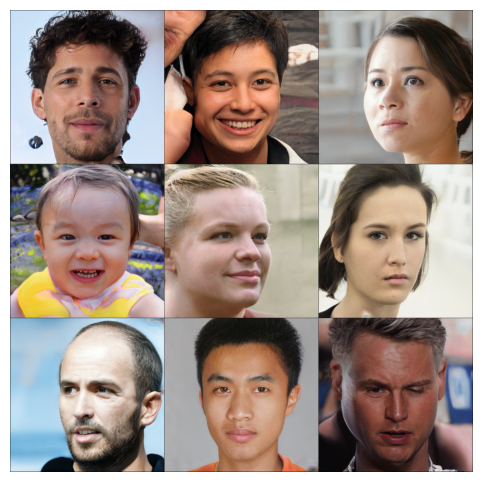

In [660]:
with torch.no_grad():
    imgs = g_all(latents)
    imgs = (imgs.clamp(-1, 1)+1)/2.0  # normalization to 0~1 range
imgs = imgs.cpu()

imgs = torchvision.utils.make_grid(imgs, nrow=nb_cols)

plt.figure(figsize=(15,6))
plt.imshow(imgs.permute(1,2,0).detach().numpy())
plt.axis('off')
plt.show()

**Step 6. Control Latent Vector**

**6-a. first random latent vector + generate first image**

In [650]:
latent1 = torch.randn(1, 512, device=device)
img1 = g_all(latent1)
img1 = img1.clamp(-1,1)+1/2.0
img1 = img1.cpu()

img1.shape

torch.Size([1, 3, 1024, 1024])

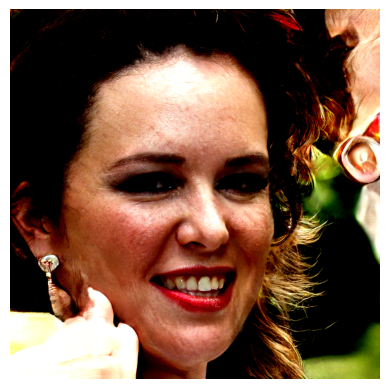

In [655]:
plt.imshow(img1.squeeze().permute(1,2,0).detach().numpy()) # drop batch (4dim -> 3dim)
plt.axis('off')
plt.show()

**6-b. second random latent vector + generate second image**

In [634]:
latent2 = torch.randn(1, 512, device=device)
img2 = g_all(latent2)
img2 = img2.clamp(-1,1)+1/2
img2 = img2.cpu()

img2.shape

torch.Size([1, 3, 1024, 1024])

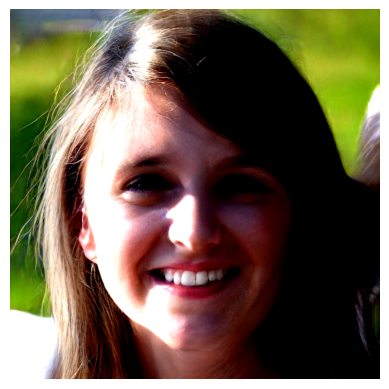

In [635]:
plt.imshow(img2.squeeze().permute(1,2,0).detach().numpy()) # drop batch (4dim -> 3dim)
plt.axis('off')
plt.show()

**6-c. half z + half z**

In [610]:
g_mapping = g_all[0] # We can extract mapping network like this.
g_mapping
g_synthesis = g_all[1]# Similarly, synthesis network can be extracted like this.
w_1 = g_mapping(latent1)
w_2 = g_mapping(latent2)


print(latent1.size(), w_1.size())
print(latent2.size(), w_2.size())

img3 = g_synthesis(w_1*0.5 + w_2*0.5)
img3 = img3.clamp(-1,1)+1/2.0
img3 = img3.cpu()

img3.shape

torch.Size([1, 512]) torch.Size([1, 18, 512])
torch.Size([1, 512]) torch.Size([1, 18, 512])


torch.Size([1, 3, 1024, 1024])

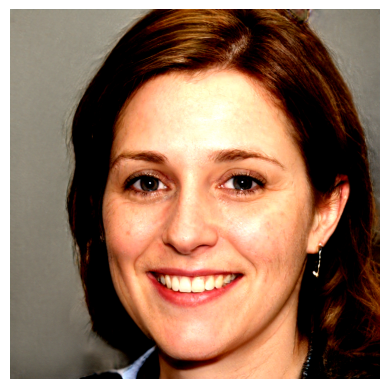

In [611]:
plt.imshow(img3.squeeze().permute(1,2,0).detach().numpy())
plt.axis('off')
plt.show()

**6-d. half w + half w**

In [514]:
g_mapping = g_all[0] # We can extract mapping network like this.
g_mapping

G_mapping(
  (pixel_norm): PixelNormLayer()
  (dense0): MyLinear()
  (dense0_act): LeakyReLU(negative_slope=0.2)
  (dense1): MyLinear()
  (dense1_act): LeakyReLU(negative_slope=0.2)
  (dense2): MyLinear()
  (dense2_act): LeakyReLU(negative_slope=0.2)
  (dense3): MyLinear()
  (dense3_act): LeakyReLU(negative_slope=0.2)
  (dense4): MyLinear()
  (dense4_act): LeakyReLU(negative_slope=0.2)
  (dense5): MyLinear()
  (dense5_act): LeakyReLU(negative_slope=0.2)
  (dense6): MyLinear()
  (dense6_act): LeakyReLU(negative_slope=0.2)
  (dense7): MyLinear()
  (dense7_act): LeakyReLU(negative_slope=0.2)
)

In [515]:
g_synthesis = g_all[1]# Similarly, synthesis network can be extracted like this.

In [612]:
w_1 = g_mapping(latent1)
w_2 = g_mapping(latent2)

The results through the MLP mapping network are as follows.

In [613]:
print(latent1.size(), w_1.size())
print(latent2.size(), w_2.size())

torch.Size([1, 512]) torch.Size([1, 18, 512])
torch.Size([1, 512]) torch.Size([1, 18, 512])


then, let's convert to image (half + half)

In [614]:
img3 = g_synthesis(w_1*0.5 + w_2*0.5)
img3 = img3.clamp(-1,1)+1/2.0
img3 = img3.cpu()

img3.shape

torch.Size([1, 3, 1024, 1024])

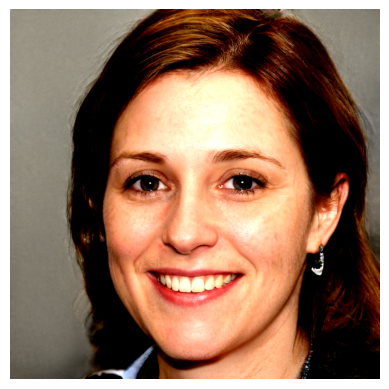

In [615]:
plt.imshow(img3.squeeze().permute(1,2,0).detach().numpy())
plt.axis('off')
plt.show()